In [2]:

#Here come my imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit


import xgboost as xgb
from scipy.fft import fft


# Using this reference. Thank you, Jason Brownlee
https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [8]:

#Load data
month_df=pd.read_csv('monthly_energy_consumption.csv',index_col=[0],parse_dates=True)
dates=month_df.index
month=month_df.values.astype('float32')
test=month[:5]
month_df

,energy
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10102660.5
2005-05-31,10181694.0
...,...
2018-03-31,11242396.5
2018-04-30,9820256.0
2018-05-31,10503052.0


In [4]:
## Loading the dataframe with previous RMSE where we stored results
results=pd.read_csv('scores.csv',index_col=[0])
results

,rmse_per_million
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


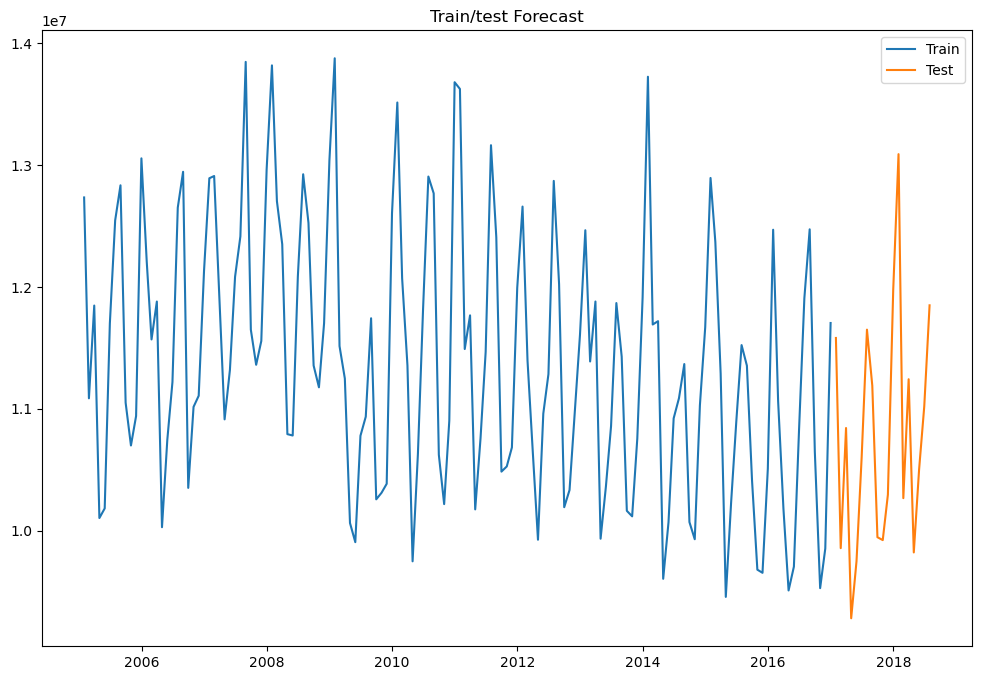

In [5]:
#This time around we have to define the number of the data points belonging to the test
n_test=len(month_df.loc['2017':'2018'])
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
#plt.plot(month_df.index[-n_test:],preds, label='RandomForest')
plt.legend(loc='best')
plt.title("Train/test Forecast");

# Third collection of Models in Time Series: <a id='start'></a>

* These methods do not provide any depth. They just take one value as a reference and project it all the way into the future.

    1. [**RandomForest**](#rf). Using Random Forest we need to create different columns with different lags<br>
    2. [**SARIMA**](#sarima). We are going to be adding Seasonality to ARIMA. We need to define apart from ARIMA's pdq, PDQ and S<br>
    3. [**FBProphet**](#prophet). Algorithm introduce by facebook (currently Menta) that is effective and easy to apply<br>


<a id='rf'></a>
## 1. RandomForest.
[back top](#start)

In [9]:
val_in=1
val_out=1
def prepping_data(data,val_in=1,val_out=1):
    """Generating the columns"""   
    df=pd.DataFrame(data)
    cols=list()
    for i in range(val_in,0,-1):
        cols.append(df.shift())
    for i in range(0,val_out):
        cols.append(df.shift(-i))
    agg=pd.concat(cols,axis=1)
    agg=agg.dropna()
    return agg.values

def my_own_train_test_split(data,n_test):
    """Our own train/test split based on the data points to test"""
    if isinstance(data,pd.DataFrame):
        return data[:-n_test], data[-n_test:]
    else:
        return data[:-n_test,:],data[-n_test:,:]

def lets_doit_rf(train, testX):
    """Making our predictions"""
    train=np.asarray(train)
    trainX,trainy=train[:,:-1],train[:,-1:]
    rf=RandomForestRegressor(n_estimators=1000)
    rf.fit(trainX, trainy.ravel())
    preds=rf.predict([testX])
    return preds

def lets_move_forward(data, n_test):
    
    #Here I will put my predictions
    predictions=[]
    #lets get our terain and test
    train, test=my_own_train_test_split(data,n_test)
    #lets line up the train
    lining_up=[x for x in train]
    for i in range(len(test)):
        testX, testy=test[i,:-1],test[i,-1]
        pred=lets_doit_rf(train,testX)
        predictions.append(pred)
        lining_up.append(test[i])
        print(f'Date {dates[-n_test+i]}. Expected {testy}, predicted {pred[0]}')
    err=mean_squared_error(test[:,-1],predictions)
    return np.sqrt(err), test[:,-1], predictions
data=prepping_data(month_df,val_in=6)
rmse,test,preds=lets_move_forward(data, n_test)
print('RMSE: ', rmse)

Date 2017-01-31 00:00:00. Expected 11581251.0, predicted 12688501.038
Date 2017-02-28 00:00:00. Expected 9855340.0, predicted 12152005.3
Date 2017-03-31 00:00:00. Expected 10841984.5, predicted 11392935.999
Date 2017-04-30 00:00:00. Expected 9279596.0, predicted 11822927.1655
Date 2017-05-31 00:00:00. Expected 9747081.0, predicted 10076613.5495
Date 2017-06-30 00:00:00. Expected 10600150.0, predicted 10587622.9725
Date 2017-07-31 00:00:00. Expected 11649628.0, predicted 10577319.492
Date 2017-08-31 00:00:00. Expected 11190134.0, predicted 11937562.345
Date 2017-09-30 00:00:00. Expected 9945277.0, predicted 11769202.685
Date 2017-10-31 00:00:00. Expected 9921554.0, predicted 10585154.591
Date 2017-11-30 00:00:00. Expected 10294894.0, predicted 10912411.422
Date 2017-12-31 00:00:00. Expected 11974478.0, predicted 10538385.386
Date 2018-01-31 00:00:00. Expected 13090587.0, predicted 12131452.888
Date 2018-02-28 00:00:00. Expected 10265918.0, predicted 12643623.4615
Date 2018-03-31 00:00:0

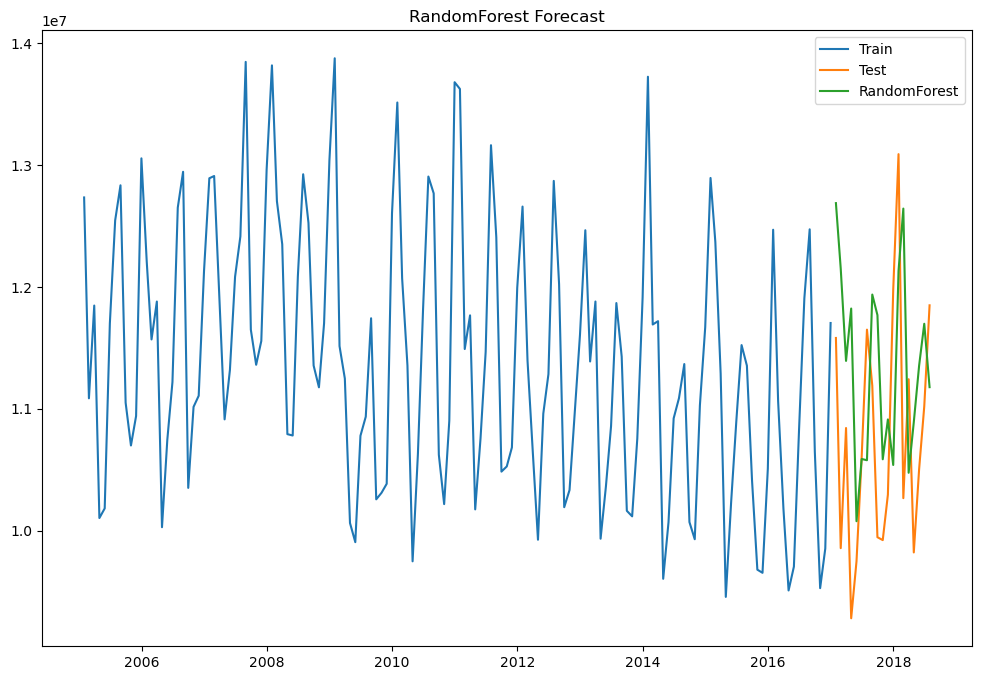

In [10]:

plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-n_test:],preds, label='RandomForest')
plt.legend(loc='best')
plt.title("RandomForest Forecast");

In [11]:
scores_df=pd.read_csv('scores.csv',index_col=[0])#['rmse']/1_000_000
scores_df.loc['RandomForest']=rmse/1_000_000
scores_df.sort_values('rmse_per_million')#.to_csv('scores.csv')

,rmse_per_million
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
RandomForest,1.282361
naive,1.325609


# XGBoost.

# Using this reference.
https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/

In [12]:
#creating lags aka look_back

def create_lag_features(data,target,lag_steps=1):
    for i in range(1,lag_steps+1):
        data[f'lag_{i}']=data[target].shift(i)

    return data
    
def create_rolling_mean(data,target,window_size=3):
    data['rolling_mean']=data[target].rolling(window=window_size).mean()
    return data
#fourier transform

def apply_fourier_transform(data,target):
    values=data[target].values
    fourier_transform=fft(values)
    data['fourier_transform']=np.abs(fourier_transform)
    return data


In [18]:
data=create_lag_features(month_df,'energy',2)
data=create_rolling_mean(data,'energy')
data=apply_fourier_transform(data,'energy')
data=data.dropna()

In [19]:
train,test = my_own_train_test_split(data,19)
X_train=train.drop('energy',axis=1)
y_train=train['energy'].values
X_test=test.drop('energy',axis=1)
y_test=test.energy.values

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
cv_split=TimeSeriesSplit(n_splits=3)
param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]

}

grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=cv_split)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [16]:
model=xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)
preds_xg=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,preds_xg))

print('Test Score: %.2f RMSE' % (rmse))


Test Score: 434517.40 RMSE


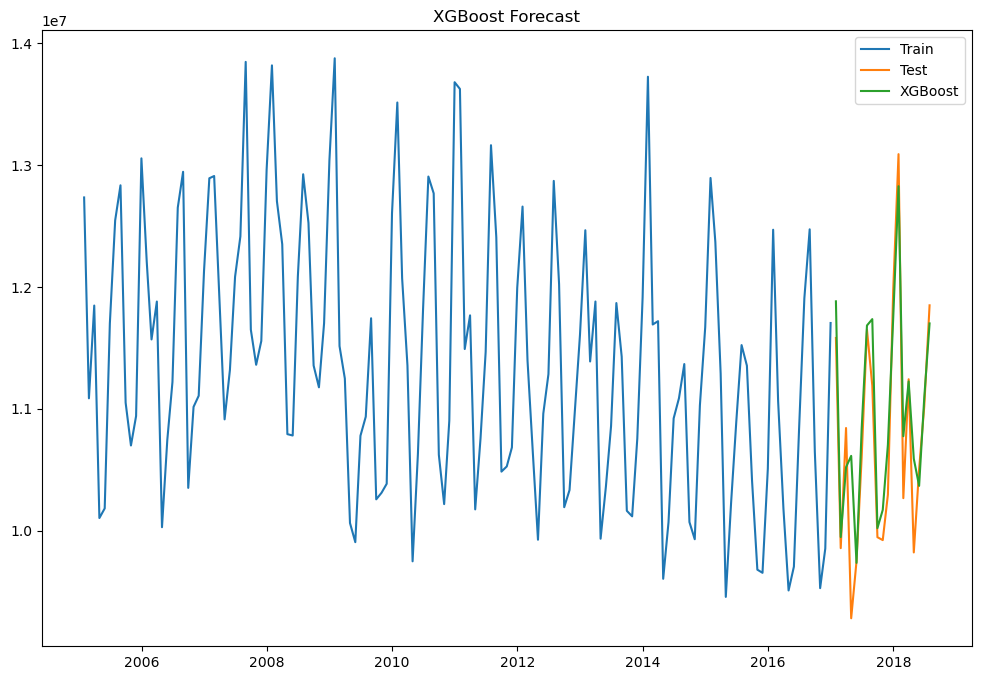

In [22]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-n_test:],preds_xg, label='XGBoost')
plt.legend(loc='best')
plt.title("XGBoost Forecast");

In [23]:
scores=pd.read_csv('scores.csv',index_col=[0])
scores.loc['XGboost']=rmse/1_000_000
scores.sort_values('rmse_per_million')#.to_csv('scores.csv')

,rmse_per_million
XGboost,0.434517
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
arima,0.737348
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177
naive,1.325609


In [24]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [1, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
grid_search = RandomizedSearchCV(RandomForestRegressor(), random_grid, cv=cv_split)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_


In [26]:
rf=RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)
preds_rf=rf.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,preds_rf))

print('Test Score: %.2f RMSE' % (rmse))


Test Score: 612968.39 RMSE


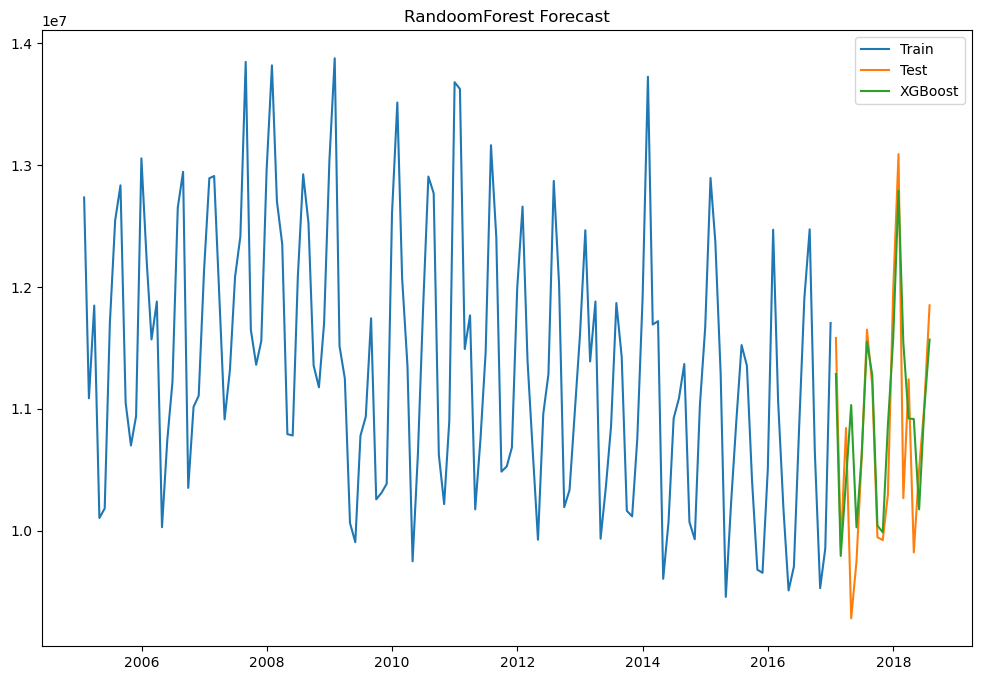

In [27]:
plt.figure(figsize=(12,8))
plt.plot(month_df.index[:-n_test], month_df.energy[:-n_test], label='Train')
plt.plot(month_df.index[-n_test:],month_df.energy[-n_test:], label='Test')
plt.plot(month_df.index[-n_test:],preds_rf, label='XGBoost')
plt.legend(loc='best')
plt.title("RandoomForest Forecast");

In [28]:

scores.loc['RandomForest']=rmse/1_000_000
scores.sort_values('rmse_per_million')#.to_csv('scores.csv')

,rmse_per_million
XGboost,0.434517
holt_winter,0.543067
prophet,0.571666
SARIMAX,0.590999
RandomForest,0.612968
arima,0.737348
holt_linear,0.929768
SES,0.942778
moving_average,0.944048
simple_average,1.122177


In [29]:
scores.sort_values('rmse_per_million').to_csv('scores.csv')